In [1]:
# Ben Caruso
# Model pipeline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix, accuracy_score, plot_roc_curve
from sklearn.model_selection import permutation_test_score
from sklearn.naive_bayes import MultinomialNB

import matplotlib.patches as mpatches

import time

import spacy
nlp = spacy.load('en_core_web_md')

### Import previously created CSVs

In [2]:
match_df = pd.read_csv('match_data.csv', index_col = 0)
total_df = pd.read_csv('total_data.csv', index_col = 0)

In [3]:
#match_df = pd.read_csv('match_data_nopron.csv', index_col = 0)
#total_df = pd.read_csv('total_data_nopron.csv', index_col = 0)

In [20]:
match_df = pd.read_csv('match_data_vector.csv', index_col = 0)
total_df = pd.read_csv('total_data_vector.csv', index_col = 0)

### Split train/test data

80/20 split chosen for the training and test data. While I'm working with a small dataset, I want to leave as much data for training as possible, but I want to make sure that I have enough test data to represent the entire sample.

In [21]:
# Create a testing split of the match data
train_match, test_match = train_test_split(match_df, test_size = 0.2, random_state = 40)

# Create a testing split of the total data
train_total, test_total = train_test_split(total_df, test_size = 0.2, random_state = 40)

### Bag of Words using CountVectorizer

In [67]:
# MATCH DATA
# Create a count vectorizer object
count_vec = CountVectorizer(max_features = 1000, stop_words = 'english', ngram_range = (1,1))
# Fit to training data of match dataframe - save vocabulary as top 500 features
count_vec.fit(train_match['passage'])
# Transform and return as sparse matrix saved as X_train
X_train_match = count_vec.transform(train_match['passage'])
# Save vocabulary
train_vocab_match = count_vec.get_feature_names()

# TOTAL DATA
# Create a count vectorizer object
count_vec_total = CountVectorizer(max_features = 1000, stop_words = 'english', ngram_range = (1,1))
# Fit to training data
count_vec_total.fit(train_total['passage'])
# Transform and return as sparse matrix saved as X_train
X_train_total = count_vec_total.transform(train_total['passage'])
# Save vocabulary
train_vocab_total = count_vec_total.get_feature_names()

In [68]:
# Obtain response vectors
y_train_match = train_match['farmer'].values
y_train_total = train_total['farmer'].values

y_test_match = test_match['farmer'].values
y_test_total = test_total['farmer'].values

### Bag of Words using Tf-idf Vectorizer

In [93]:
# MATCH DATA
# Create a tf-idf vectorizer object
tfidf_vec = TfidfVectorizer(max_features = 1000, stop_words = 'english', ngram_range = (1,1))
# Fit to training data of match dataframe - save vocabulary as top 1000 features
tfidf_vec.fit(train_match['passage'])
# Transform and return as sparse matrix saved as X_train
X_train_match = tfidf_vec.transform(train_match['passage'])
# Save vocabulary
train_vocab_match = tfidf_vec.get_feature_names()

# TOTAL DATA
# Create a count vectorizer object
tfidf_vec_total = TfidfVectorizer(max_features = 1000, stop_words = 'english', ngram_range = (1,1))
# Fit to training data
tfidf_vec_total.fit(train_total['passage'])
# Transform and return as sparse matrix saved as X_train
X_train_total = tfidf_vec_total.transform(train_total['passage'])
# Save vocabulary
train_vocab_total = tfidf_vec_total.get_feature_names()

In [12]:
len(train_vocab_total)

720

In [13]:
len(train_vocab_match)

883

### Distributed Representations (Word Embeddings)

In [111]:
import nltk
import string

def tokenize(text):
    stem = nltk.stem.SnowballStemmer('english')
    text = text.lower()

    for token in nltk.word_tokenize(text):
        if token in string.punctuation: continue
        yield stem.stem(token)

corpus = train_match['passage'] 

In [112]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec

corpus = [list(tokenize(doc)) for doc in corpus]
corpus = [
    TaggedDocument(words, ['d{}'.format(idx)])
    for idx, words in enumerate(corpus)
]

model = Doc2Vec(corpus, size=5, min_count=0)
print(model.docvecs[0])
# [ 0.09744903 -0.09999768  0.02523494 -0.06081665  0.11068201]

[ 0.09744903 -0.09999768  0.02523494 -0.06081665  0.11068201]


In [123]:
df = {}

for vec in model.docvecs:
    print(vec)

[ 0.09744903 -0.09999768  0.02523494 -0.06081665  0.11068201]
[-0.00543762  0.08880792  0.01461806 -0.10905612  0.09117828]
[-0.0650697  -0.09839911  0.01823969  0.02991779  0.09169203]
[ 0.02082063 -0.06016931  0.11283208 -0.10569695  0.00564952]
[ 0.11035868 -0.00058851 -0.01148387  0.0056311  -0.01858203]
[-0.01780507  0.01283289  0.06664248  0.00626268  0.08321886]
[ 0.07087712 -0.04923321  0.05904696 -0.0799678   0.05647953]
[ 0.08272161  0.02382687  0.00574048 -0.04031454 -0.00803761]
[-0.05612763  0.08270972  0.04812307  0.07579213  0.07195717]
[-0.00131375  0.07548465 -0.06003805  0.06798516  0.11295383]
[ 0.13642083  0.01728984  0.10429361 -0.1194394   0.00876584]
[-0.07117627 -0.09510278  0.11828578  0.02998178 -0.03223126]
[-0.06408554  0.06929216  0.02247851  0.02818996  0.00578293]
[-0.00808167 -0.02895895  0.05411069 -0.10688912 -0.04503211]
[ 0.08165522  0.04337304 -0.0387175   0.07951026  0.05137722]
[-0.05437183  0.01653824 -0.0439876  -0.00721546  0.06202724]
[-0.0755

KeyError: "tag '308' not seen in training corpus/invalid"

### Distributed Representations (using spaCy's pretrained model vectors)

In [22]:
y_train_match = train_match['farmer'].values
X_train_match = train_match.drop(['passage', 'farmer'],axis=1)

X_train_match.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
312,0.026759,0.131887,-0.183663,-0.046858,0.049209,0.035723,0.006746,-0.030806,-0.069914,2.109776,...,-0.154170,0.018181,0.014293,-0.206608,0.049132,0.055168,-0.123463,-0.123568,0.139095,0.023450
102,-0.064984,0.171429,-0.197156,-0.042675,-0.034425,0.047622,-0.025541,0.074471,-0.000513,2.164666,...,-0.273280,0.214946,0.030715,-0.166919,0.040601,0.024175,-0.109563,-0.040799,0.057021,0.069363
340,-0.035423,0.241367,-0.210483,-0.139259,-0.145432,0.031638,0.029721,-0.011860,-0.170936,1.975800,...,-0.173775,0.226937,-0.006934,-0.191026,0.150906,0.107065,-0.142242,0.024931,-0.014300,0.109334
162,-0.029822,0.146852,-0.114647,-0.052513,0.105075,-0.012867,-0.074489,-0.011723,0.017984,2.142946,...,-0.258092,0.095849,0.042163,-0.078893,-0.055545,-0.058468,-0.039391,-0.071084,0.034284,0.085074
288,0.012223,0.106940,-0.098285,-0.015597,0.173176,0.007261,0.027602,0.000274,-0.016739,1.800526,...,-0.189681,0.088219,0.071801,-0.055286,0.010979,-0.119935,-0.081292,-0.006678,0.004191,0.078861


In [23]:
X_test_match.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
51,0.029165,0.207331,-0.161187,-0.036417,0.040588,0.046905,0.070176,-0.141163,0.014646,1.469625,...,-0.102137,0.062464,-0.141844,-0.149470,0.209689,-0.119034,-0.130945,-0.057008,-0.031787,0.102484
3,-0.189016,0.178327,-0.072908,-0.111463,0.017320,0.204892,0.097854,0.184326,-0.176410,1.746020,...,-0.155960,0.263842,0.053773,-0.145820,0.147790,-0.077678,-0.240220,0.103400,0.015525,0.082614
43,-0.050446,0.160873,-0.152124,-0.078974,-0.048613,0.029668,-0.023624,0.012960,-0.033945,2.440198,...,-0.327137,0.120171,-0.030668,-0.219510,0.015390,0.046391,-0.119620,-0.053635,-0.004951,0.094903
62,-0.019569,0.094865,-0.192742,0.008534,0.064215,-0.015044,0.022205,-0.146363,-0.035636,1.963093,...,-0.177042,0.088069,0.034711,-0.124650,0.032715,0.058615,0.000784,-0.089088,0.104943,0.008908
227,-0.035159,0.211945,-0.230875,-0.084937,-0.030258,0.048065,0.057634,-0.058130,-0.107508,2.114090,...,-0.194930,0.143978,-0.110773,-0.178984,0.159478,0.072744,-0.150120,-0.066186,0.079920,0.112070


In [14]:
# Define logistic regression model
log_mod = LogisticRegression()
# Fit the model to the training data
log_mod.fit(X_train_match, y_train_match)
# Score the model on the training data
train_acc = log_mod.score(X_train_match, y_train_match)
print(f'Training Accuracy on keyword passages: {round(train_acc * 100, 2)}%')

Training Accuracy on keyword passages: 80.52%


In [15]:
y_test_match = test_match['farmer'].values
X_test_match = test_match.drop(['passage','farmer'],axis=1)

In [16]:
# Obtain test accuracy
test_acc_match = log_mod.score(X_test_match, y_test_match)
y_pred = log_mod.predict(X_test_match)
# Get accuracy
lm_acc_match = accuracy_score(y_pred, y_test_match)
print(f'Test Accuracy on matched passages: {round(test_acc_match * 100, 4)}%')
print(classification_report(y_test_match, y_pred))

Test Accuracy on matched passages: 58.9744%
              precision    recall  f1-score   support

           0       0.54      0.69      0.61        36
           1       0.66      0.50      0.57        42

    accuracy                           0.59        78
   macro avg       0.60      0.60      0.59        78
weighted avg       0.60      0.59      0.59        78



### Logistic Regression Baseline Model on SVD-applied frequency matrix

In [ ]:
pd.DataFrame(X_train_match.todense(), columns=train_vocab_match)

In [ ]:
# Obtain SVD
U, S, V = np.linalg.svd(bow_mat)

# Define sigma matrix as same size as A with sigma values on the diagonal
sigma = np.zeros(bow_mat.shape)

# Check if n or p is greater
# Want to use the smaller index to assign the diagonals
if bow_mat.shape[1] > bow_mat.shape[0]:
    sigma[:bow_mat.shape[0], :bow_mat.shape[0]] = np.diag(S)
else:
    sigma[:bow_mat.shape[1], :bow_mat.shape[1]] = np.diag(S)

# Now recreate matrix using new approximation - zeros are represented as tiny numbers
#print(U @ sigma @ V)

# Obtain first two columns of each matrix
V2 = V[:,:2]
S2 = sigma[:2,:2]
U2 = U[:,:2]

### Logistic Regression Baseline on vectors

In [89]:
# Now, the features are vectors based on spaCy's pretrained model rather than a bag of words vector
X_train_match = train_match['vector']

In [139]:
train_match['vector'].apply(lambda x: x.replace('[', '').replace(']', ''))

0    -5.36380261e-02  1.91823944e-01 -1.87215120e-0...
0    -1.20261200e-01  1.60843715e-01 -1.82370648e-0...
Name: vector, dtype: object

In [97]:
train_match['vector'].apply(lambda x: x.split())

205    [[-1.39729649e-01, 2.16673151e-01, -1.72136053...
171    [[-1.91573035e-02, 8.53235945e-02, -2.37105176...
133    [[-5.99660352e-02, 1.93175286e-01, -1.98324293...
123    [[-3.60984914e-02, 1.81379423e-01, -1.27776295...
209    [[-5.60138449e-02, 1.06217459e-01, -1.75774604...
                             ...                        
64     [[-1.32865146e-01, 1.95578843e-01, -1.99429989...
94     [[-1.26494234e-02, 1.78652599e-01, -1.98529080...
6      [[-6.10299967e-02, 7.49959946e-02, 4.26400006e...
131    [[-2.11082175e-01, 2.30013698e-01, -1.38643995...
37     [[, 3.88976038e-02, 1.26552984e-01, -1.4532688...
Name: vector, Length: 308, dtype: object

In [91]:
type(X_train_match)

pandas.core.series.Series

In [118]:
# Define logistic regression model
log_mod = LogisticRegression()
# Score the model on the training data
train_acc = cross_val_score(log_mod, model.docvecs, y_train_match, cv = 10)
print(f'Training Accuracy on keyword passages using CV: {round(np.mean(train_acc) * 100, 2)}%')

# Define logistic regression model
log_mod = LogisticRegression()
# Fit the model to the training data
log_mod.fit(model.docvecs, y_train_match)
# Score the model on the training data
train_acc = log_mod.score(model.docvecs, y_train_match)
print(f'Training Accuracy on keyword passages: {round(train_acc * 100, 2)}%')

Training Accuracy on keyword passages using CV: 56.47%


ValueError: setting an array element with a sequence.

In [78]:
# Transform test matrices for keyword data
X_test_match = count_vec.transform(test_match['passage'])
y_test_match = test_match['farmer']

# Transform test matrices for total data
X_test_total = count_vec_total.transform(test_total['passage'])
y_test_total = test_total['farmer']

In [80]:
test_acc_match = log_mod.score(X_test_match, y_test_match)
y_pred = log_mod.predict(X_test_match)
# Get accuracy
lm_acc_match = accuracy_score(y_pred, y_test_match)
print(f'Test Accuracy on matched passages: {round(test_acc_match * 100, 4)}%')
print(classification_report(y_test_match, y_pred))

Test Accuracy on matched passages: 51.2821%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.52      0.98      0.68        41

    accuracy                           0.51        78
   macro avg       0.26      0.49      0.34        78
weighted avg       0.27      0.51      0.36        78



### Logistic Regression Baseline Model

In [14]:
# Define logistic regression model
log_mod = LogisticRegression()
# Score the model on the training data
train_acc = cross_val_score(log_mod, X_train_match, y_train_match, cv = 10)
print(f'Training Accuracy on keyword passages using CV: {round(np.mean(train_acc) * 100, 2)}%')

# Define logistic regression model for total data
log_mod_total = LogisticRegression()
# Score the model on the training data
train_acc_total = cross_val_score(log_mod_total, X_train_total, y_train_total, cv = 10)
print(f'Training Accuracy on general passages using CV: {round(np.mean(train_acc_total) * 100, 2)}%')

Training Accuracy on keyword passages using CV: 68.82%
Training Accuracy on general passages using CV: 57.94%


In [15]:
# Define logistic regression model
log_mod = LogisticRegression()
# Fit the model to the training data
log_mod.fit(X_train_match, y_train_match)
# Score the model on the training data
train_acc = log_mod.score(X_train_match, y_train_match)
print(f'Training Accuracy on keyword passages: {round(train_acc * 100, 2)}%')

# Define logistic regression model for total data
log_mod_total = LogisticRegression()
# Fit the model to the training data
start_time = time.time()
log_mod_total.fit(X_train_total, y_train_total)
# Score the model on the training data
train_acc_total = log_mod_total.score(X_train_total, y_train_total)
print(f'Training Accuracy on general passages: {round(train_acc_total * 100, 2)}%')

Training Accuracy on keyword passages: 93.18%
Training Accuracy on general passages: 92.83%


### Test Performance

#### Using same CountVectorizer as training data and simply transforming the test data based on its vocabulary

In [226]:
# Transform test matrices for keyword data
X_test_match = count_vec.transform(test_match['passage'])
y_test_match = test_match['farmer']

# Transform test matrices for total data
X_test_total = count_vec_total.transform(test_total['passage'])
y_test_total = test_total['farmer']

In [227]:
test_acc_match = log_mod.score(X_test_match, y_test_match)
y_pred = log_mod.predict(X_test_match)
# Get accuracy
lm_acc_match = accuracy_score(y_pred, y_test_match)
print(f'Test Accuracy on matched passages: {round(test_acc_match * 100, 4)}%')
print(classification_report(y_test_match, y_pred))

Test Accuracy on matched passages: 70.5128%
              precision    recall  f1-score   support

           0       0.70      0.68      0.69        38
           1       0.71      0.72      0.72        40

    accuracy                           0.71        78
   macro avg       0.71      0.70      0.70        78
weighted avg       0.71      0.71      0.70        78



In [228]:
test_acc_total = log_mod_total.score(X_test_total, y_test_total)
y_pred = log_mod_total.predict(X_test_total)
# Get accuracy
lm_acc_total = accuracy_score(y_pred, y_test_total)
print(f'Test Accuracy on general passages: {round(test_acc_total * 100, 4)}%')
print(classification_report(y_test_total, y_pred))

Test Accuracy on general passages: 50.6494%
              precision    recall  f1-score   support

           0       0.53      0.59      0.56        41
           1       0.47      0.42      0.44        36

    accuracy                           0.51        77
   macro avg       0.50      0.50      0.50        77
weighted avg       0.50      0.51      0.50        77



Both models seem to perform significantly worse when ngrams larger than 1 are used. I don't know why this is, but it could be because the model prefers comparing only the single words used as opposed to phrases.

Permutation test on these two models perhaps?

#### Using same TfidfVectorizer as training data and simply transforming the test data based on its vocabulary

In [16]:
# Transform test matrices for keyword data
X_test_match = tfidf_vec.transform(test_match['passage'])
y_test_match = test_match['farmer']

# Transform test matrices for total data
X_test_total = tfidf_vec_total.transform(test_total['passage'])
y_test_total = test_total['farmer']

In [17]:
test_acc_match = log_mod.score(X_test_match, y_test_match)
y_pred = log_mod.predict(X_test_match)
# Get accuracy
lm_acc_match = accuracy_score(y_pred, y_test_match)
print(f'Test Accuracy on matched passages: {round(test_acc_match * 100, 4)}%')
print(classification_report(y_test_match, y_pred))

Test Accuracy on matched passages: 67.9487%
              precision    recall  f1-score   support

           0       0.66      0.71      0.68        38
           1       0.70      0.65      0.68        40

    accuracy                           0.68        78
   macro avg       0.68      0.68      0.68        78
weighted avg       0.68      0.68      0.68        78



In [18]:
test_acc_total = log_mod_total.score(X_test_total, y_test_total)
y_pred = log_mod_total.predict(X_test_total)
# Get accuracy
lm_acc_total = accuracy_score(y_pred, y_test_total)
print(f'Test Accuracy on general passages: {round(test_acc_total * 100, 4)}%')
print(classification_report(y_test_total, y_pred))

Test Accuracy on general passages: 51.9481%
              precision    recall  f1-score   support

           0       0.56      0.49      0.52        41
           1       0.49      0.56      0.52        36

    accuracy                           0.52        77
   macro avg       0.52      0.52      0.52        77
weighted avg       0.52      0.52      0.52        77



Based on running identical tests for logistic regression, the Tfidf-Vectorizer seems to perform slightly worse than the countvectorizer on the test match data, whereas it performs 0.3% better on the test total data.

### SVM

For a second model as a metric of comparison, I'll try to use SVM with varying kernels on the dataset to see which performs the best.

SVM has a few advantages, which seem to coincide with my dataset:

Good with small datasets - my dataset is only 380 instances

Great for high-dimensional data - text data with countvectorizer or word embeddings has many dimensions

In [229]:
pipelineSVM = Pipeline([
    ("Vectorizer", CountVectorizer(max_features = 1000, stop_words = 'english')),
    ("SVM (Sigmoid)", SVC(kernel = 'sigmoid', C = 100, gamma = 0.001))
])

In [230]:
# Pass in training data features and labels
pipelineSVM.fit(train_match['passage'], y_train_match)

Pipeline(steps=[('Vectorizer',
                 CountVectorizer(max_features=1000, stop_words='english')),
                ('SVM (Sigmoid)', SVC(C=100, gamma=0.001, kernel='sigmoid'))])

In [231]:
y_pred = pipelineSVM.predict(test_match['passage'])
# Get accuracy
svm_acc_match = accuracy_score(y_pred, y_test_match)
print(classification_report(y_pred, y_test_match))
print(confusion_matrix(y_pred, y_test_match))

              precision    recall  f1-score   support

           0       0.61      0.79      0.69        29
           1       0.85      0.69      0.76        49

    accuracy                           0.73        78
   macro avg       0.73      0.74      0.73        78
weighted avg       0.76      0.73      0.74        78

[[23  6]
 [15 34]]


**Active model prediction**

In [232]:
text = input("Enter sentence: \n")

text = np.array([text])
if (pipelineSVM.predict(text) == 0):
    print('Expert')
elif (pipelineSVM.predict(text) == 1):
    print('Farmer')

Enter sentence: 
hello!
Farmer


In [346]:
# Fit to total data
pipelineSVM.fit(train_total['passage'], y_train_total)
y_pred = pipelineSVM.predict(test_total['passage'])
# Get accuracy
svm_acc_total = accuracy_score(y_pred, y_test_total)
print(classification_report(y_pred, y_test_total))
print(confusion_matrix(y_pred, y_test_total))


              precision    recall  f1-score   support

           0       0.34      0.61      0.44        23
           1       0.75      0.50      0.60        54

    accuracy                           0.53        77
   macro avg       0.55      0.55      0.52        77
weighted avg       0.63      0.53      0.55        77

[[14  9]
 [27 27]]


AttributeError: lower not found

In [ ]:
plot_confusion_matrix(pipelineSVM, X_test_match, y_test_match, cmap = 'Greens')
plot_confusion_matrix(pipelineSVM, X_test_total, y_test_total, cmap = 'Greens')

In [190]:
rdm_params = {'C': [10 ** x for x in range(-10, 10)],
                'kernel': ['rbf', 'sigmoid', 'linear'],
                'gamma': [1e-3, 1e-4]}

grid_params = {'kernel': ['rbf'], 
               'gamma': [1e-3, 1e-4], 
               'C': [10 ** x for x in range(-5, 5)],
               'kernel': ['sigmoid'],
               'C': [10 ** x for x in range(-5, 5)]}
               #'kernel': ['linear'],
               #'C': [10 ** x for x in range(-5, 5)]}

#rdm_cv = RandomizedSearchCV(SVC(), scoring = 'accuracy', param_grid = tuned_params, refit = False)
grid_cv = GridSearchCV(SVC(), scoring = 'accuracy', param_grid = grid_params, refit = False)

grid_cv.fit(X_train_match, y_train_match)

print(grid_cv.best_params_)

#print(f"Best C found for training dataset: {best_C}")
grid_cv.best_params_

{'C': 10000, 'gamma': 0.001, 'kernel': 'sigmoid'}


### Confusion Matrix for Logistic Regression

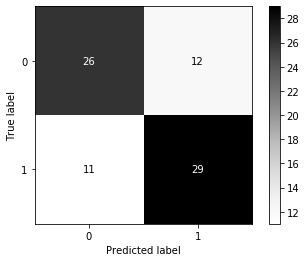

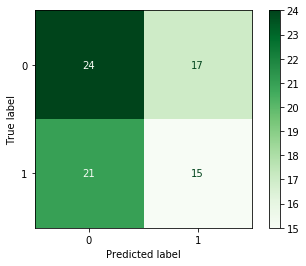

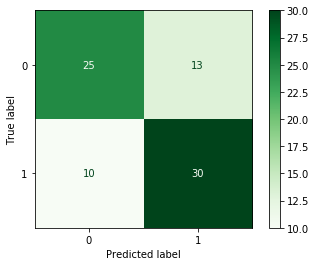

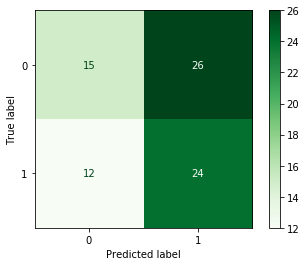

In [349]:
plot_confusion_matrix(log_mod, X_test_match, y_test_match, cmap = 'Greys')
plot_confusion_matrix(log_mod_total, X_test_total, y_test_total, cmap = 'Greens')

rf.fit(X_train_match, y_train_match)
plot_confusion_matrix(rf, X_test_match, y_test_match, cmap = 'Greens')
rf.fit(X_train_total, y_train_total)
plot_confusion_matrix(rf, X_test_total, y_test_total, cmap = 'Greens')

### Random Forest model with feature importance

In [280]:
# Create random forest model
rf = RandomForestClassifier(max_depth = 10, random_state = 0)

# Fit random forest model
rf.fit(X_train_match, y_train_match)

# Train accuracy
scores = cross_val_score(rf, X_train_match, y_train_match)
print(f'Mean training accuracy achieved: {np.mean(scores)} +/- {np.std(scores)}')

Mean training accuracy achieved: 0.6846641988365944 +/- 0.05716148488005938


In [236]:
y_pred = rf.predict(X_test_match)
# Get accuracy
rf_acc_match = accuracy_score(y_pred, y_test_match)
print(classification_report(y_pred, y_test_match))
print(confusion_matrix(y_pred, y_test_match))

              precision    recall  f1-score   support

           0       0.66      0.71      0.68        35
           1       0.75      0.70      0.72        43

    accuracy                           0.71        78
   macro avg       0.70      0.71      0.70        78
weighted avg       0.71      0.71      0.71        78

[[25 10]
 [13 30]]


In [237]:
# Fit random forest model
rf.fit(X_train_total, y_train_total)
y_pred = rf.predict(X_test_total)
# Get accuracy
rf_acc_total = accuracy_score(y_pred, y_test_total)
print(classification_report(y_pred, y_test_total))
print(confusion_matrix(y_pred, y_test_total))

              precision    recall  f1-score   support

           0       0.37      0.56      0.44        27
           1       0.67      0.48      0.56        50

    accuracy                           0.51        77
   macro avg       0.52      0.52      0.50        77
weighted avg       0.56      0.51      0.52        77

[[15 12]
 [26 24]]


### Multinomial Naive Bayes

In [297]:
mnb = MultinomialNB()

In [313]:
mnb.fit(X_train_match, y_train_match)

y_pred = mnb.predict(X_test_match)

print(classification_report(y_pred, y_test_match))

              precision    recall  f1-score   support

           0       0.68      0.62      0.65        42
           1       0.60      0.67      0.63        36

    accuracy                           0.64        78
   macro avg       0.64      0.64      0.64        78
weighted avg       0.65      0.64      0.64        78



In [314]:
mnb.fit(X_train_total, y_train_total)

y_pred = mnb.predict(X_test_total)

print(classification_report(y_pred, y_test_total))

              precision    recall  f1-score   support

           0       0.49      0.53      0.51        38
           1       0.50      0.46      0.48        39

    accuracy                           0.49        77
   macro avg       0.49      0.49      0.49        77
weighted avg       0.49      0.49      0.49        77



### Permutation Tests

In [332]:
print("Match Data:\n")
score1, permutation_scores1, pvalue1 = permutation_test_score(log_mod, 
                                                          X_test_match, y_test_match,
                                                         scoring = "accuracy", cv = 10, 
                                                          n_permutations = 100, n_jobs = 1)
print("Classification score for logistic regression: %s (pvalue : %s)\n" % (score1, pvalue1))
score2, permutation_scores2, pvalue2 = permutation_test_score(SVC(kernel = 'sigmoid', C = 100, gamma = 0.001), 
                                                          X_test_match, y_test_match,
                                                         scoring = "accuracy", cv = 10, 
                                                          n_permutations = 100, n_jobs = 1)
print("Classification score for SVM: %s (pvalue : %s)\n" % (score2, pvalue2))
score3, permutation_scores3, pvalue3 = permutation_test_score(rf, 
                                                          X_test_match, y_test_match,
                                                         scoring = "accuracy", cv = 10, 
                                                          n_permutations = 100, n_jobs = 1)
print("Classification score for random forest: %s (pvalue : %s)\n" % (score3, pvalue3))

Match Data:

Classification score for logistic regression: 0.6428571428571429 (pvalue : 0.009900990099009901)

Classification score for SVM: 0.6571428571428571 (pvalue : 0.009900990099009901)

Classification score for random forest: 0.5785714285714285 (pvalue : 0.1188118811881188)



In [333]:
print("Total Data:\n")
score4, permutation_scores4, pvalue4 = permutation_test_score(log_mod_total, 
                                                          X_test_total, y_test_total,
                                                         scoring = "accuracy", cv = 10, 
                                                          n_permutations = 100, n_jobs = 1)
print("Classification score for logistic regression: %s (pvalue : %s)\n" % (score4, pvalue4))
score5, permutation_scores5, pvalue5 = permutation_test_score(SVC(kernel = 'sigmoid', C = 100, gamma = 0.001), 
                                                          X_test_total, y_test_total,
                                                         scoring = "accuracy", cv = 10, 
                                                          n_permutations = 100, n_jobs = 1)
print("Classification score for SVM: %s (pvalue : %s)\n" % (score5, pvalue5))
score6, permutation_scores6, pvalue6 = permutation_test_score(rf, 
                                                          X_test_total, y_test_total,
                                                         scoring = "accuracy", cv = 10, 
                                                          n_permutations = 100, n_jobs = 1)
print("Classification score for random forest: %s (pvalue : %s)\n" % (score6, pvalue6))

Total Data:

Classification score for logistic regression: 0.5660714285714287 (pvalue : 0.19801980198019803)

Classification score for SVM: 0.5464285714285714 (pvalue : 0.297029702970297)

Classification score for random forest: 0.5160714285714286 (pvalue : 0.49504950495049505)



In [429]:
pvalue1, pvalue2, pvalue3, pvalue4, pvalue5, pvalue6

(0.009900990099009901,
 0.009900990099009901,
 0.1188118811881188,
 0.19801980198019803,
 0.297029702970297,
 0.49504950495049505)

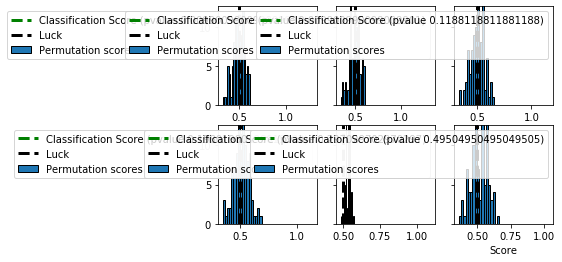

In [398]:
stats = [[score1, permutation_scores1, pvalue1],[score2, permutation_scores2, pvalue2],
         [score3, permutation_scores3, pvalue3],[score4, permutation_scores4, pvalue4],
        [score5, permutation_scores5, pvalue5],[score6, permutation_scores6, pvalue6]]
n_classes = 2

subplots = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2)]
counter = 0
# View histogram of permutation scores
fig, axs = plt.subplots(2, 3, sharey = True)

for index,model_stats in enumerate(stats):
    plt.subplot
    axs[subplots[counter][0], subplots[counter][1]].hist(model_stats[1], 18, label='Permutation scores',
             edgecolor='black')
    ylim = plt.ylim()
    axs[subplots[counter][0], subplots[counter][1]].plot(2 * model_stats[0], ylim[1]-ylim[0], '--g', linewidth=3,
             label='Classification Score (pvalue %s)' % model_stats[2])
    axs[subplots[counter][0], subplots[counter][1]].plot(2 * [1. / n_classes], ylim, '--k', linewidth=3, label='Luck')

    plt.ylim(ylim)
    axs[subplots[counter][0], subplots[counter][1]].legend()
    plt.xlabel('Score')
    
    counter += 1
    
plt.show()

In [425]:
def plot_perm_score(score, permutation_scores, pvalue, title):
    n_classes = 2
    plt.hist(permutation_scores, 20, label='Permutation scores',
             edgecolor='black')
    ylim = plt.ylim()
  
    plt.plot(2 * [score], ylim, '--g', linewidth=3,
             label='Classification Score'
             ' (pvalue %s)' % round(pvalue, 4))
    plt.plot(2 * [1. / n_classes], ylim, '--k', linewidth=3, label='Null Model (50%)')

    plt.ylim(ylim)
    plt.legend()
    plt.xlabel('Score')
    plt.title(title)
    plt.show()

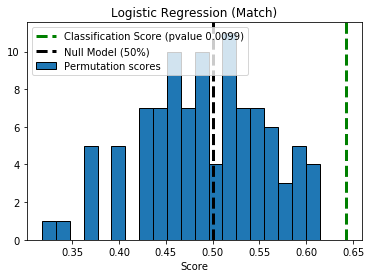

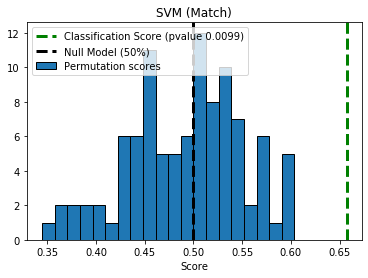

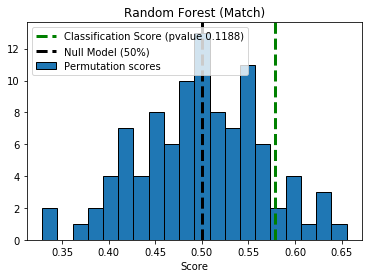

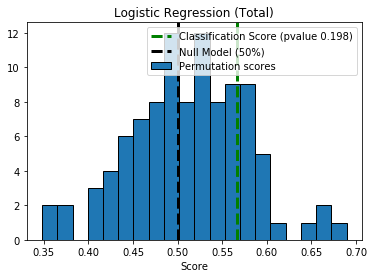

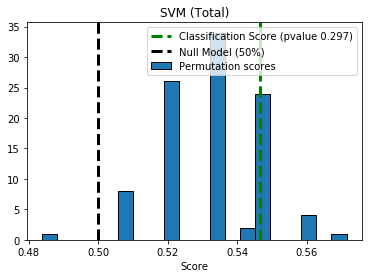

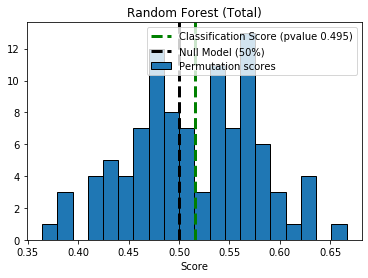

In [427]:
stats = [[score1, permutation_scores1, pvalue1],[score2, permutation_scores2, pvalue2],
         [score3, permutation_scores3, pvalue3],[score4, permutation_scores4, pvalue4],
        [score5, permutation_scores5, pvalue5],[score6, permutation_scores6, pvalue6]]
plot_perm_score(stats[0][0], stats[0][1], stats[0][2], "Logistic Regression (Match)")
plot_perm_score(stats[1][0], stats[1][1], stats[1][2], "SVM (Match)")
plot_perm_score(stats[2][0], stats[2][1], stats[2][2], "Random Forest (Match)")
plot_perm_score(stats[3][0], stats[3][1], stats[3][2], "Logistic Regression (Total)")
plot_perm_score(stats[4][0], stats[4][1], stats[4][2], "SVM (Total)")
plot_perm_score(stats[5][0], stats[5][1], stats[5][2], "Random Forest (Total)")

''

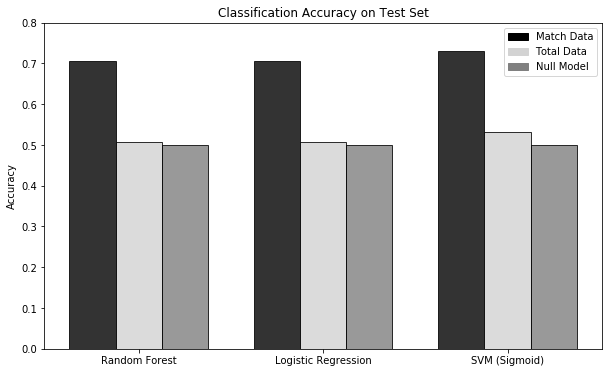

In [350]:
# Build plot comparing the three models by accuracy on the validation set

plt.figure(figsize=(10, 6))

# Define groups to plot
match_accs = [rf_acc_match, lm_acc_match, svm_acc_match]
total_accs = [rf_acc_total, lm_acc_total, svm_acc_total]
# Define bar width
bar_width = 0.25

# Set up x coordinates
r = np.arange(len(match_accs))
r2 = [x + bar_width for x in r]
r3 = [x + bar_width for x in r2]

plt.bar(r, match_accs, color = 'black', width = bar_width, edgecolor = 'black', alpha = 0.8)
plt.bar(r2, total_accs, color = 'lightgray', width = bar_width, edgecolor = 'black', alpha = 0.8)
plt.bar(r3, 0.50, color = 'gray', width = bar_width, edgecolor = 'black', alpha = 0.8)

# Add title
plt.title('Classification Accuracy on Test Set')
plt.ylabel('Accuracy')
plt.ylim((0, 0.8))
# Add xlabels
plt.xticks([r + bar_width for r in range(len(match_accs))], ['Random Forest', 'Logistic Regression', 'SVM (Sigmoid)'])

# Create legend
blue = mpatches.Patch(color = 'black', label = 'Match Data')
orange = mpatches.Patch(color = 'lightgray', label = 'Total Data')
gray = mpatches.Patch(color = 'gray', label = 'Null Model')

plt.legend(handles=[blue, orange, gray])

;

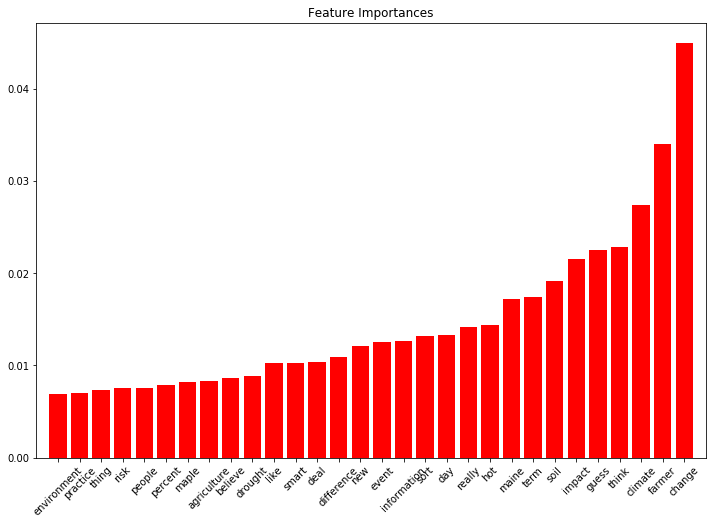

In [217]:
# Build graph of feature importances of random forest
importances = rf.feature_importances_

std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis = 0)

# Sorting importances
indices = np.argsort(importances)[::1]

top_indices = indices[-30:]

top_vocab = [train_vocab_match[index] for index in top_indices]

# Print feature ranking
#print("Feature ranking:")

#for f in range(X_train_match.shape[1]):
   # print(f"{f + 1}. Feature {top_indices[f]} ({importances[top_indices[f]]})")
    
#for f in range(top_indices.shape[0]):
   # print(f"{f + 1}. Feature {top_indices[f]} ({importances[top_indices[f]]})")
    
# Create plot
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(top_vocab, importances[top_indices], 
        color = 'r', align = 'center')

plt.xticks(rotation = 45)
plt.xlim([-1, len(top_vocab)])
plt.show()

In [313]:
top_indices = indices[-30:]

In [318]:
top_indices.shape[0]

30

#### Look at the distribution between the classes to evaluate the model

If the model solely predicted the common class (the speaker was a farmer), then a 50% accuracy would have been achieved due to the exact even distribution of the classes. Thus, this model is able to use the words used by each speaker to predict who is talking with 17.5% greater percentage of accuracy than a null model.

Furthermore, the model pipeline fitted to the climate change keyword passages has an accuracy of 12 points greater than the model fit to the general speaker data. This provides clear evidence that there is a distinction between the speech of farmers and experts on how they discuss climate change topics that goes deeper than just the natural language differences between how they talk in general.

### Visualization of Most Popular Words Spoken

In [308]:
def word_importance(model_with_coefs):
    # Create dataframe relating the features to their coefficients for matches
    # Coefficients are obtained from accessing the logistic regression model directly
    # Features are obtained through the vocabulary used in the CountVectorizer object
    feature_coefs = {}

    for index, key in enumerate(train_vocab_match):
        feature_coefs[key] = [model_with_coefs.coef_[0][index]]


    feature_coef_df = pd.DataFrame(feature_coefs)
    
    coefs_feature = {}

    # Reverse feature-coefficient dictionary for later mapping
    for key in feature_coefs:
        coefs_feature[feature_coefs[key][0]] = key

    coefs_list = []
    for key in coefs_feature:
        coefs_list.append(key)

    # Most negative
    expert_coefs_list = sorted(coefs_list)[:10]

    # Most positive
    farmer_coefs_list = sorted(coefs_list, reverse = True)[:10]
    # Reverse list to make plot easier to read
    farmer_coefs_list.reverse()

    fig = plt.figure(figsize=(12,8))

    # greater positive coefficient: more likely to be farmer (1)
    top_10_farmer = [coefs_feature[coef] for coef in farmer_coefs_list]
    top_10_expert = [coefs_feature[coef] for coef in expert_coefs_list]

    print("Words most associated with farmer:",top_10_farmer)
    print("Words most associated with expert:",top_10_expert)

    # Define dictionary mapping features to coefficients for top 10 spam/ham words
    df_dict = {}
    for coef in expert_coefs_list:
        df_dict[coefs_feature[coef]] = [coef]
    for coef in farmer_coefs_list:
        df_dict[coefs_feature[coef]] = [coef]

    # Convert to dataframe
    data = pd.DataFrame(df_dict)

    # Create plot with labels
    sns.barplot(data = data, orient = 'h', palette = 'gist_earth')
    plt.suptitle("Most common words spoken", fontsize = 16)
    plt.title("Negative coefficients correspond to expert's words, positive correspond to farmer's")
    plt.xlabel('Coefficient')
    plt.ylabel('Feature')
    ;

Words most associated with farmer: ['notice', 'long', 'fast', 'control', 'hard', 'environment', 'conference', 'percent', 'hot', 'guess']
Words most associated with expert: ['impact', 'farmer', 'deal', 'new', 'maine', 'information', 'really', 'happen', 'soil', 'practice']


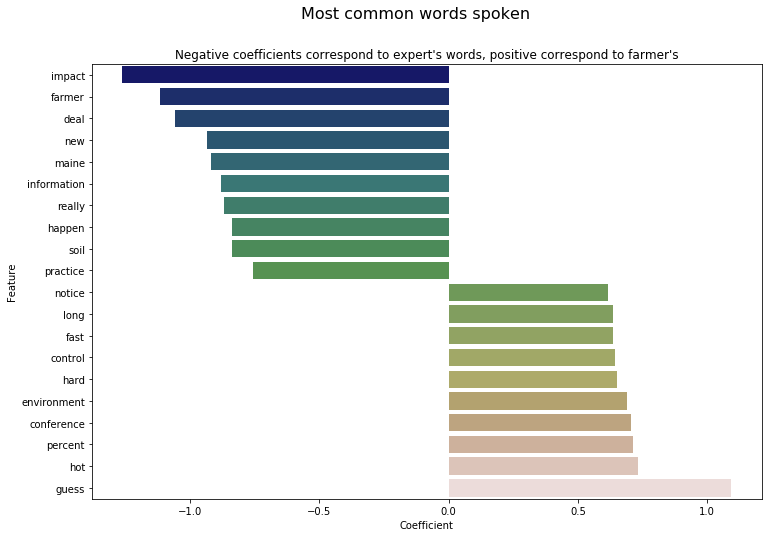

In [311]:
word_importance(log_mod)

Words most associated with farmer: ['make', 'just', 'year', 'think', 'thing', 'know', 'weather', 'change', 'climate', 'agriculture']
Words most associated with expert: ['youth', 'yes', 'wool', 'winter', 'start', 'yeah', 'work', 'really', 'vermont', 'say']


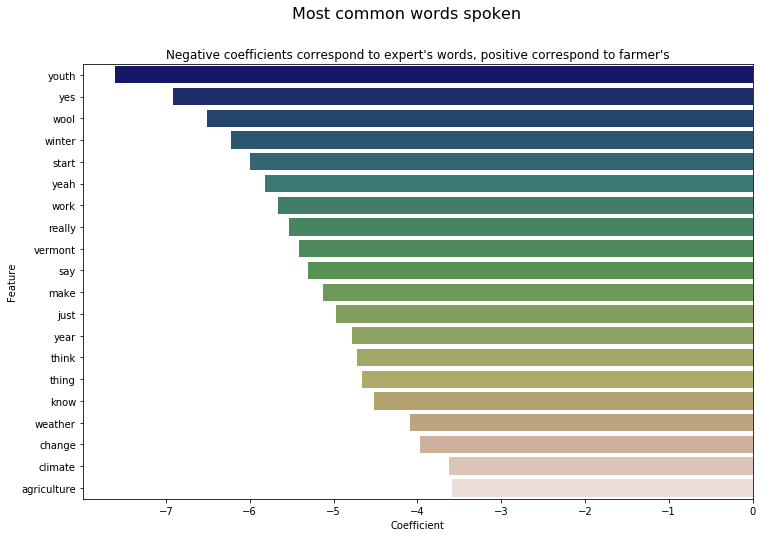

In [312]:
word_importance(mnb)

In [234]:
# Most negative
top_exp = sorted(coefs_list)[:25]

# Most positive
top_farmer = sorted(coefs_list, reverse = True)[:30]
# Reverse list to make plot easier to read
top_farmer.reverse()

# greater positive coefficient: more likely to be farmer (1)
# Get top 50 words for both farmer and expert
top_50_farmer = [coefs_feature[coef] for coef in top_farmer]
top_50_expert = [coefs_feature[coef] for coef in top_exp]

In [235]:
# Convert top 50 words to vectors using spaCy's vectorization
top_farmer_vecs = [nlp(word).vector for word in top_50_farmer]
top_exp_vecs = [nlp(word).vector for word in top_50_expert]

# Define farmer and expert vocabulary - total set of words
farmer_vocab = list(set(top_50_farmer))
expert_vocab = list(set(top_50_expert))

# Define dataframes for both
farm_df = pd.DataFrame(top_farmer_vecs)
exp_df = pd.DataFrame(top_exp_vecs)

In [236]:
# Obtain correlation matrix of each dataframe
X_f_corr = farm_df.corr()
X_e_corr = exp_df.corr()

# Compute eigen values and eigen vectors given the correlation matrix
f_values, f_vectors = np.linalg.eig(X_f_corr)
e_values, e_vectors = np.linalg.eig(X_e_corr)

# Sorting the eigen vectors coresponding to eigen values in descending order
# Farmer
f_args = (-f_values).argsort()
f_values = f_vectors[f_args]
f_vectors = f_vectors[:, f_args]
# Expert
e_args = (-e_values).argsort()
e_values = e_vectors[e_args]
e_vectors = e_vectors[:, e_args]

# Taking first 2 components which explain maximum variance for projecting
f_new_vectors = f_vectors[:,:2]
e_new_vectors = e_vectors[:,:2]

# Projecting it onto new dimesion with 2 axis
f_new_X = np.dot(top_farmer_vecs,f_new_vectors)
e_new_X = np.dot(top_exp_vecs,e_new_vectors)

''

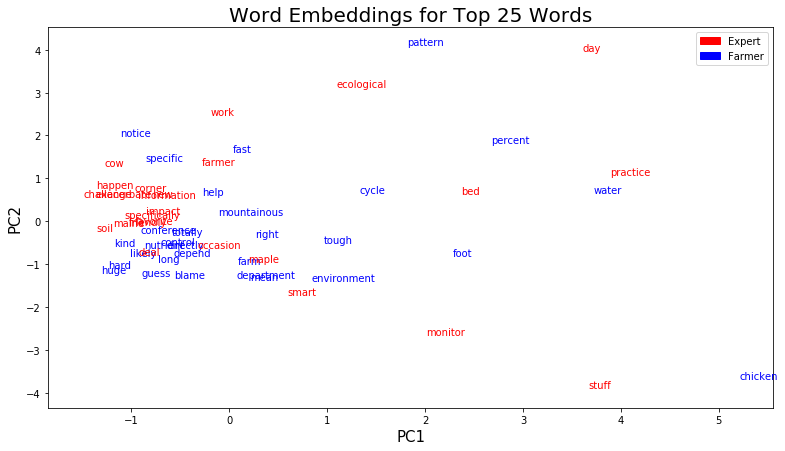

In [238]:
plt.figure(figsize=(13,7)) # Set figure size

plt.scatter(f_new_X[:,0], f_new_X[:,1], c = 'None', linewidths=10) # Create scatter plot
plt.scatter(e_new_X[:,0], e_new_X[:,1], c = 'None', linewidths=10)

# X = first eigenvector (PC1), Y = second eigenvector (PC2)

# Set x and y labels and title
plt.xlabel("PC1",size=15)
plt.ylabel("PC2",size=15)
plt.title("Word Embeddings for Top 25 Words",size=20)

# Define vocab and annotate each point with name
for i, word in enumerate(farmer_vocab):
    plt.annotate(str(word), xy = (f_new_X[i,0],f_new_X[i,1]), color = 'blue')
    
for i, word in enumerate(expert_vocab):
    plt.annotate(str(word), xy = (e_new_X[i,0], e_new_X[i,1]), color = 'red')

# Create legend
red = mpatches.Patch(color = 'red', label = 'Expert')
blue = mpatches.Patch(color = 'blue', label = 'Farmer')
plt.legend(handles=[red, blue])
;

The above plot was made in the hopes that there would be distinguishable clusters between expert and farmer words in two dimension embeddings, but unfortunately that does not appear to be the case. 